In [ ]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.applications import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
#from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
# time libraries
import time
import datetime
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/BAN'
train_dir = data_dir+'/TRAIN'
test_dir = data_dir+'/TEST'

In [ ]:
# Define image size
IMAGE_SIZE = (224, 224)

# Define batch size
BATCH_SIZE = 64


# Create ImageDataGenerator for training set with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.1,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True)

# Create ImageDataGenerator for validation and test sets without data augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create train, validation, and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
    )

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
    )

Found 703 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'CRACKED': 0, 'NORMAL': 1}

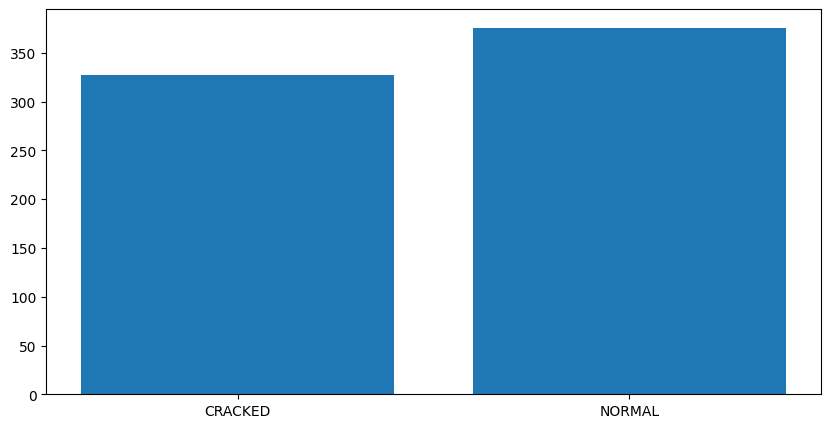

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(2):
    num_values.append(valdict[i])
plt.figure(figsize=(10,5))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()

In [ ]:
# Get the first batch of images
images, _ = next(train_generator)

# Get the shape of the images
shape = images[0].shape

# Print the shape of the images
print(f'The shape of the images is: {shape}')

The shape of the images is: (224, 224, 3)


In [ ]:
# Create VGG16 model with pre-trained weights
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
# Freeze pre-trained layers
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
train_generator.num_classes

2

In [ ]:
# Add new classification layers
top_model = tf.keras.models.Sequential()
top_model.add(tf.keras.layers.Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(tf.keras.layers.Dense(256, activation='relu'))
top_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# Create new model
model = tf.keras.models.Model(inputs=vgg16_model.input, outputs=top_model(vgg16_model.output))

In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy']
)

In [ ]:
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt" #pake yang ini
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1)


class EpochEndByAcc(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.80):
      print("\nAkurasi di atas 80%, hentikan training!")
      self.model.stop_training = True

valacc = EpochEndByAcc()

In [ ]:
# calculating computational time
t = time.perf_counter()

# Train model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[cp_callback,valacc],
    verbose=2)

# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\nTraining time:', elapsed_time)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.75077, saving model to training_1/cp-0001.ckpt
11/11 - 62s - loss: 0.2191 - accuracy: 0.9246 - val_loss: 0.5876 - val_accuracy: 0.7508 - 62s/epoch - 6s/step
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.75077
11/11 - 59s - loss: 0.1843 - accuracy: 0.9331 - val_loss: 0.7267 - val_accuracy: 0.7046 - 59s/epoch - 5s/step
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.75077
11/11 - 56s - loss: 0.1938 - accuracy: 0.9303 - val_loss: 0.6677 - val_accuracy: 0.7200 - 56s/epoch - 5s/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.75077
11/11 - 57s - loss: 0.1789 - accuracy: 0.9445 - val_loss: 0.6776 - val_accuracy: 0.7169 - 57s/epoch - 5s/step
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.75077
11/11 - 77s - loss: 0.1841 - accuracy: 0.9374 - val_loss: 0.6717 - val_accuracy: 0.7169 - 77s/epoch - 7s/step
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.75077
11/11 - 56s - loss: 0.1692 - a

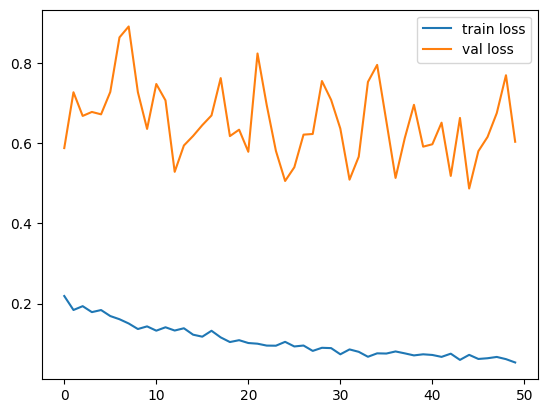

<Figure size 640x480 with 0 Axes>

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

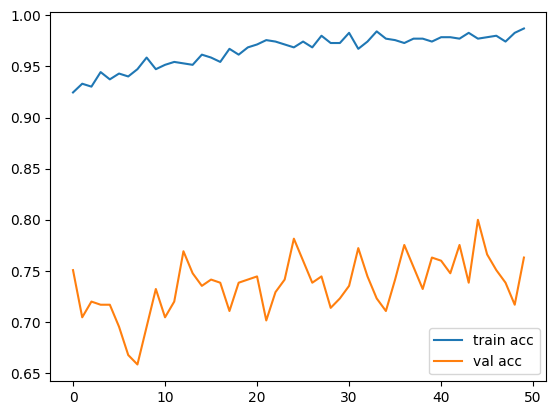

<Figure size 640x480 with 0 Axes>

In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

6/6 [==============================] - 23s 4s/step
Confusion Matrix
Confusion matrix, without normalization
Classification report
              precision    recall  f1-score   support

     CRACKED       0.65      1.00      0.79       210
      NORMAL       0.00      0.00      0.00       115

    accuracy                           0.65       325
   macro avg       0.32      0.50      0.39       325
weighted avg       0.42      0.65      0.51       325



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


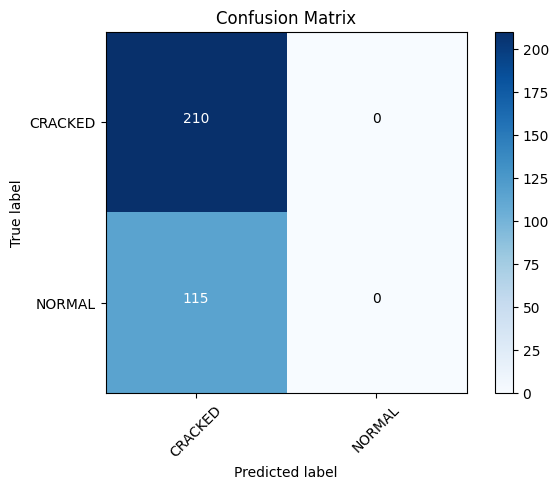

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


target_names = []
for key in train_generator.class_indices:
  target_names.append(key)

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
print('Classification report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))